In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from definitions import ROOT_DIR
from unc.utils import load_info

In [10]:
size = 9
fs_path = Path(ROOT_DIR, 'snapshot', 'results', 'fs', str(size))
f_path = Path(ROOT_DIR, 'snapshot', 'results', 'f', str(size))
fp_path = Path(ROOT_DIR, 'snapshot', 'results', 'fp', str(size))

fpg_path = Path(ROOT_DIR, 'snapshot', 'results', 'fpg', str(size))
fsg_path = Path(ROOT_DIR, 'snapshot', 'results', 'fsg', str(size))

# fpm_path = Path(ROOT_DIR, 'snapshot', 'results', 'fpm', str(size))
# fpv_path = Path(ROOT_DIR, 'snapshot', 'results', 'fpv', str(size))

f_color = 'black'
fs_color = 'peachpuff'
fp_color = 'lightgreen'

fsg_color = 'darkorange'
fpg_color = 'forestgreen'


def moving_avg(x, mode='valid', w=100):
    return np.convolve(x, np.ones(w), mode=mode) / w

In [4]:
def process_dir(dir_path, key="reward", w=100, trunc=60000, split_by=None):
    if split_by is not None:
        all_results = {}
    else:
        all_results = []
        
    for f in dir_path.iterdir():
        info = load_info(f)
        args = info['args'].item()
        
        if split_by is not None:
            hparams = tuple(args[s] for s in split_by)
            split_by_tuple = tuple(split_by)
            if split_by_tuple not in all_results:
                all_results[split_by_tuple] = {}
            
            if hparams not in all_results[split_by_tuple]:
                all_results[split_by_tuple][hparams] = []
                
            if trunc > info[key].shape[0]:
                print(args)
                print(f"length of misbehaving data: {info[key].shape}")
                
            result = moving_avg(info[key][:trunc], w=w)
            all_results[split_by_tuple][hparams].append(result)
            
        else:
            result = moving_avg(info[key][:trunc], w=w)
            all_results.append(result)
    if split_by is not None:
        for k, v in all_results.items():
            for k1, v1 in v.items():
                all_results[k][k1] = np.array(all_results[k][k1])
        data = all_results
    else:
        data = np.array(all_results)

    
    return data

In [5]:
w = 100
f_data = process_dir(f_path, w=w, trunc=150000)
fs_data = process_dir(fs_path, w=w, trunc=150000)
fp_data = process_dir(fp_path, w=w, trunc=150000)

fpg_data = process_dir(fpg_path, w=w, trunc=150000)
fsg_data = process_dir(fsg_path, w=w, trunc=150000)

In [12]:
all_data = [
    ('color only (|o| = 5)', f_data, f_color),
    ('state obs (|o| = 3 + 5)', fs_data, fs_color),
    ('one-hot state obs (|o| = 196 + 5)', fsg_data, fsg_color),
    ('pf obs (|o| = 6 + 5)', fp_data, fp_color),
    ('all-state uncertainty obs (|o| = 196 + 5)', fpg_data, fpg_color)
]

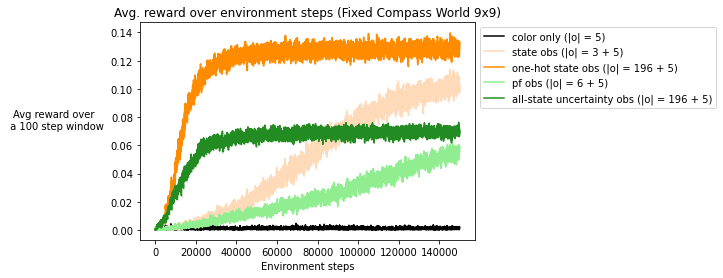

In [13]:
x = np.arange(f_data.shape[1])
fig, ax = plt.figure(), plt.axes()


for key, data, color in all_data:
    means = data.mean(axis=0)
    std_err = data.std(axis=0) / data.shape[0]

    ax.plot(x, means, label=key, color=color)
    plt.fill_between(x, means - std_err, means + std_err,
                         color=color, alpha=0.2)

ax.set_xlabel('Environment steps')
ax.set_ylabel(f"Avg reward over \n a {w} step window", rotation=0, labelpad=55)
ax.set_title(f'Avg. reward over environment steps (Fixed Compass World {size}x{size})')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')